In [61]:
import hvplot.pandas
import folium
from folium import plugins
from folium.plugins import HeatMap
import pandas as pd
import requests
import cartopy
import geoviews
import pyproj
import geopy
import matplotlib.pyplot as plt
import holoviews
import numpy as np
import geopandas as gpd
# Import API key
from api_keys import geoapify_key
from api_keys import weather_api_key

# Visualizing Poverty
In this section we take a file that has every us county and each of their respective poverty rates for 1960-2010

In [10]:
#load csv for the poverty rates by county from 1960-2010
county_df= pd.read_csv("../Project 1/Poverty-Rates-by-County-1960-2010.csv")

#county_df

In [11]:
# Drop rows with any missing data
county_df.dropna(how='any', inplace=True)
#county_df

In [14]:
#Add a column to county_df called "rate change" that is the difference between poverty rates in 2010 and 1960. 
county_df["Rate Change"]= county_df["Poverty Rate 2010"]-county_df["Poverty Rate 1960"]
#county_df

# Top 10 counties for poverty rate change 1960-2010

In [105]:
#sort by the rate change, most poverty increase to least (high positive rate is bad, high negative rate is good).
sort_rate_df = county_df.sort_values(by="Rate Change", ascending=False).reset_index()

#show the ten worst counties for poverty rate increase
sort_rate_df[["State","County","Rate Change"]].head(10)


State        County  Rate Change
0  Washington      Whitman          19.6
1       Idaho      Madison          14.7
2     Montana      Mineral          14.5
3    Virginia  Radford city         12.9
4    New York        Bronx          12.6
5      Oregon      Sherman          12.5
6       Texas    Ochiltree          11.1
7   Wisconsin    Milwaukee          11.1
8     Montana      Liberty          10.2
9      Nevada    Esmeralda           9.9

# Top 10 states for poverty rate change 1960-2010

In [115]:
#only take the rows where the county name is called State Total
total_state = sort_rate_df[sort_rate_df["County"] == "State Total"]
#Sort
sort_total_state = total_state.sort_values(by="Rate Change", ascending=False).reset_index()

#show the top 10 worst states
sort_total_state[["State","County","Rate Change"]].head(10)

State       County  Rate Change
0         Nevada  State Total          1.4
1     California  State Total          0.9
2       New York  State Total          0.7
3         Oregon  State Total          0.4
4    Connecticut  State Total          0.4
5       Michigan  State Total          0.4
6           Ohio  State Total         -0.5
7       Illinois  State Total         -1.0
8  Massachusetts  State Total         -1.2
9     New Jersey  State Total         -1.4

# This is a graph on total state rate change from 1960 to 2010

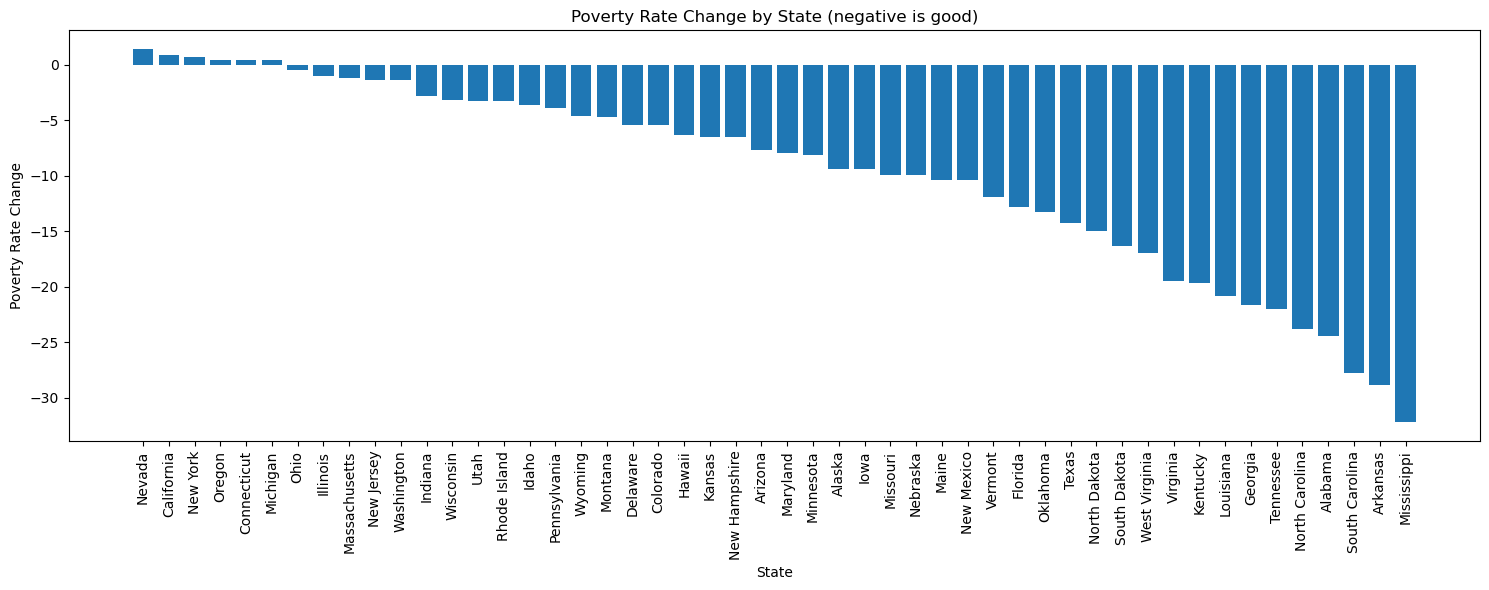

<Figure size 640x480 with 0 Axes>

In [114]:
state = total_state["State"]
rate = total_state["Rate Change"]
# Create a larger figure to prevent crowding
plt.figure(figsize=(15, 6))

# Create a bar plot
plt.bar(state, rate)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add labels and a title
plt.xlabel("State")
plt.ylabel("Poverty Rate Change")
plt.title("Poverty Rate Change by State (negative is good)")

# Show the plot
plt.tight_layout()
plt.show()
plt.savefig('all_states_poverty_rate_change.png')

# This is a graph on state total poverty in 2010

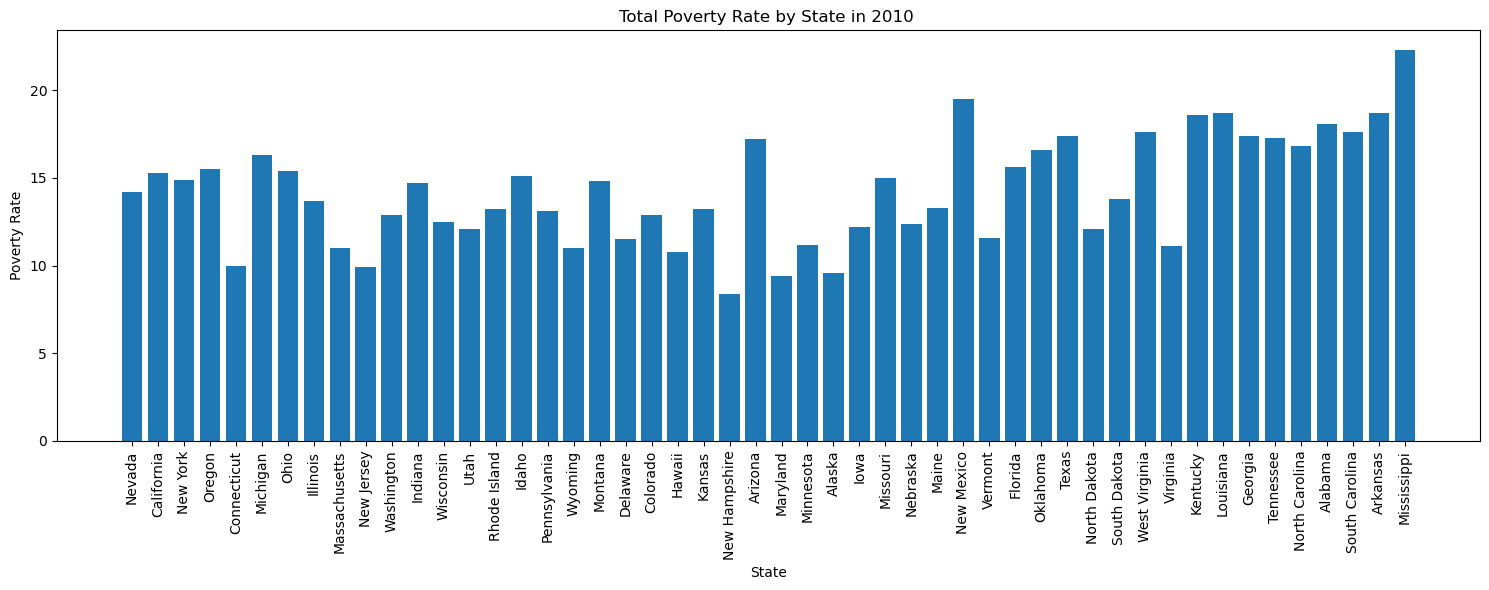

In [22]:
state = total_state["State"]
rate = total_state["Poverty Rate 2010"]
# Create a larger figure to prevent crowding
plt.figure(figsize=(15, 6))

# Create a bar plot
plt.bar(state, rate)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add labels and a title
plt.xlabel("State")
plt.ylabel("Poverty Rate")
plt.title("Total Poverty Rate by State in 2010 ")

# Show the plot
plt.tight_layout()
plt.show()

# This is a line graph showing the states total poverty rate for each decade reported

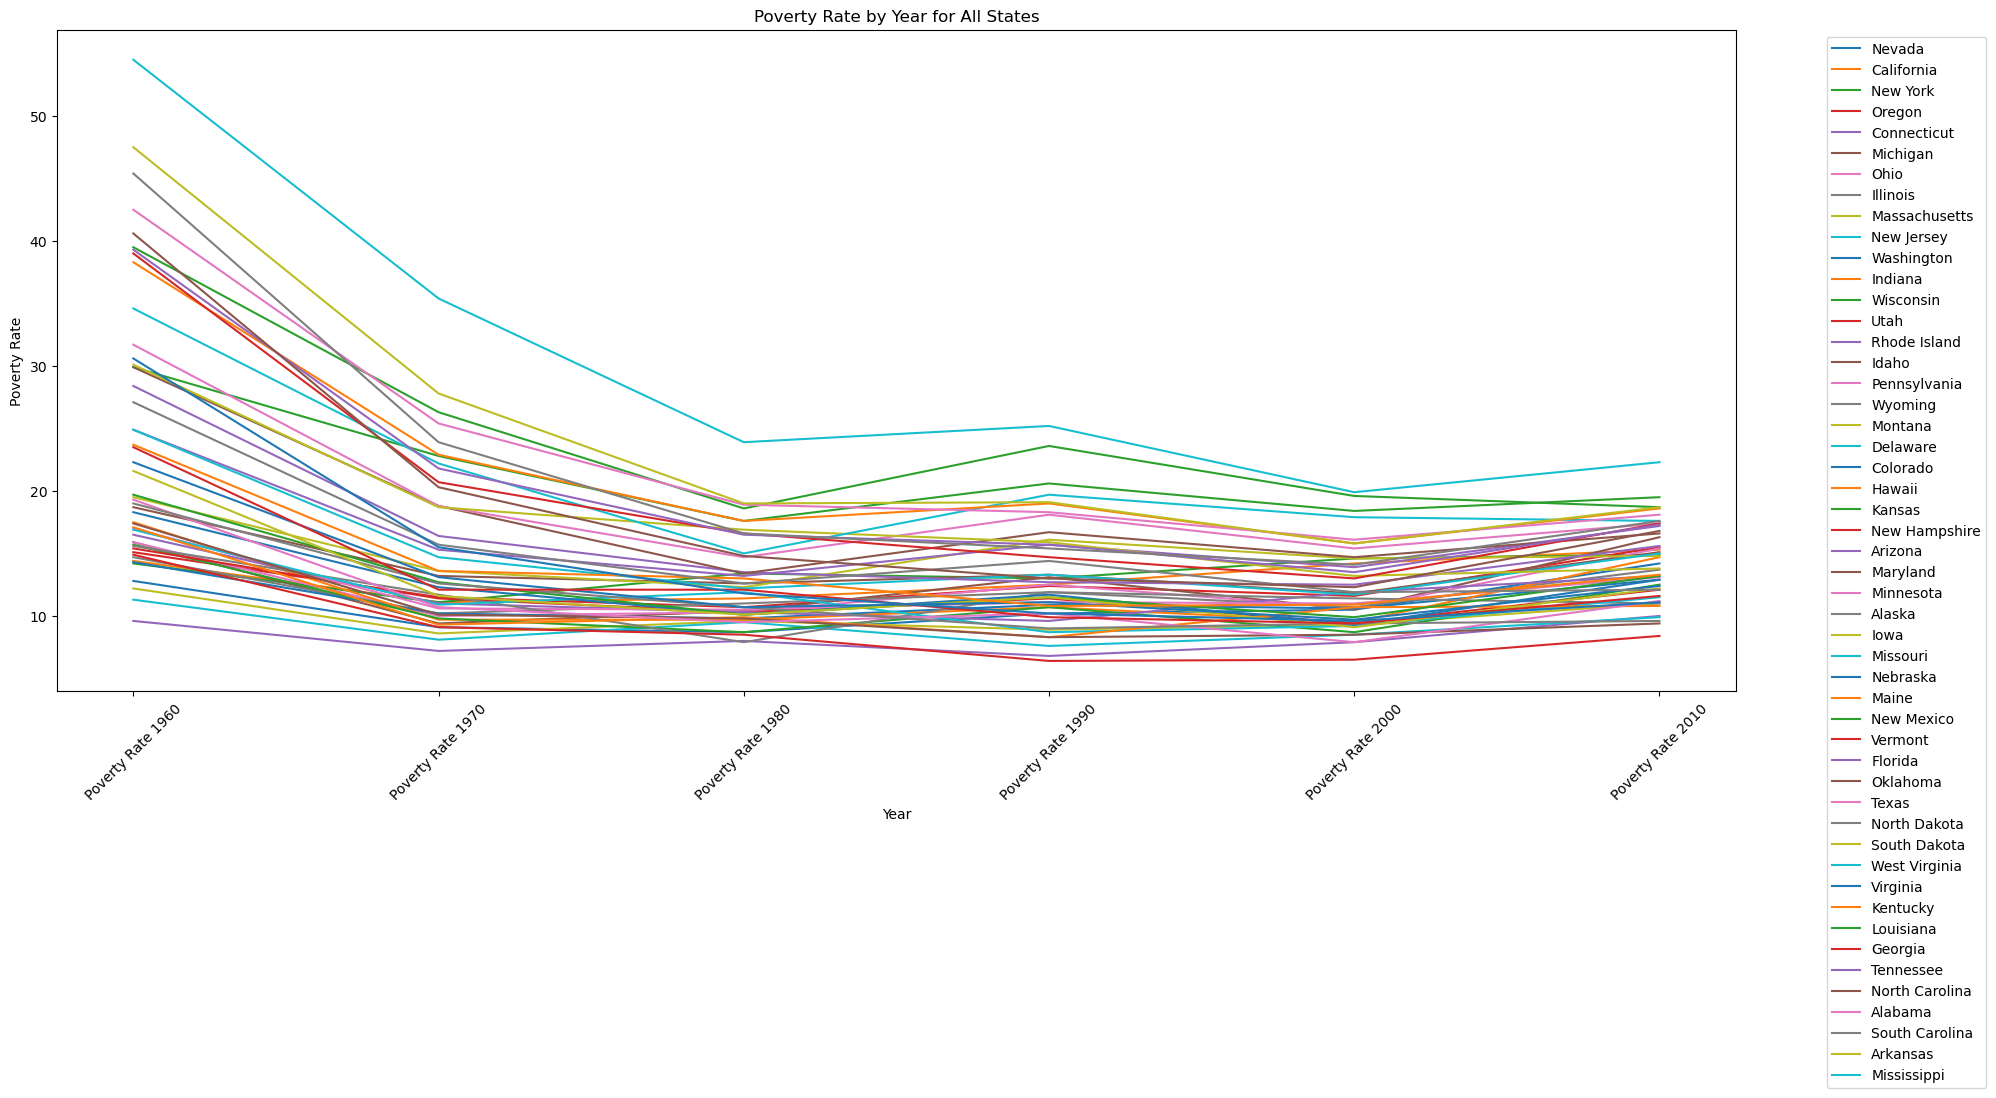

In [31]:

# Extract the years and Rate for all states
years = ["Poverty Rate 1960", "Poverty Rate 1970", "Poverty Rate 1980", "Poverty Rate 1990", "Poverty Rate 2000", "Poverty Rate 2010"]


# Create a larger figure for better visualization
plt.figure(figsize=(20, 10))

# Iterate through each state and plot its line
for index, row in total_state.iterrows():
    state = row["State"]
    rates = row[years]
    plt.plot(years, rates, label=state)
# Customize the plot
plt.xlabel("Year")
plt.ylabel("Poverty Rate")
plt.title("Poverty Rate by Year for All States")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move the legend outside the plot


# Show the plot
plt.tight_layout()
plt.show()



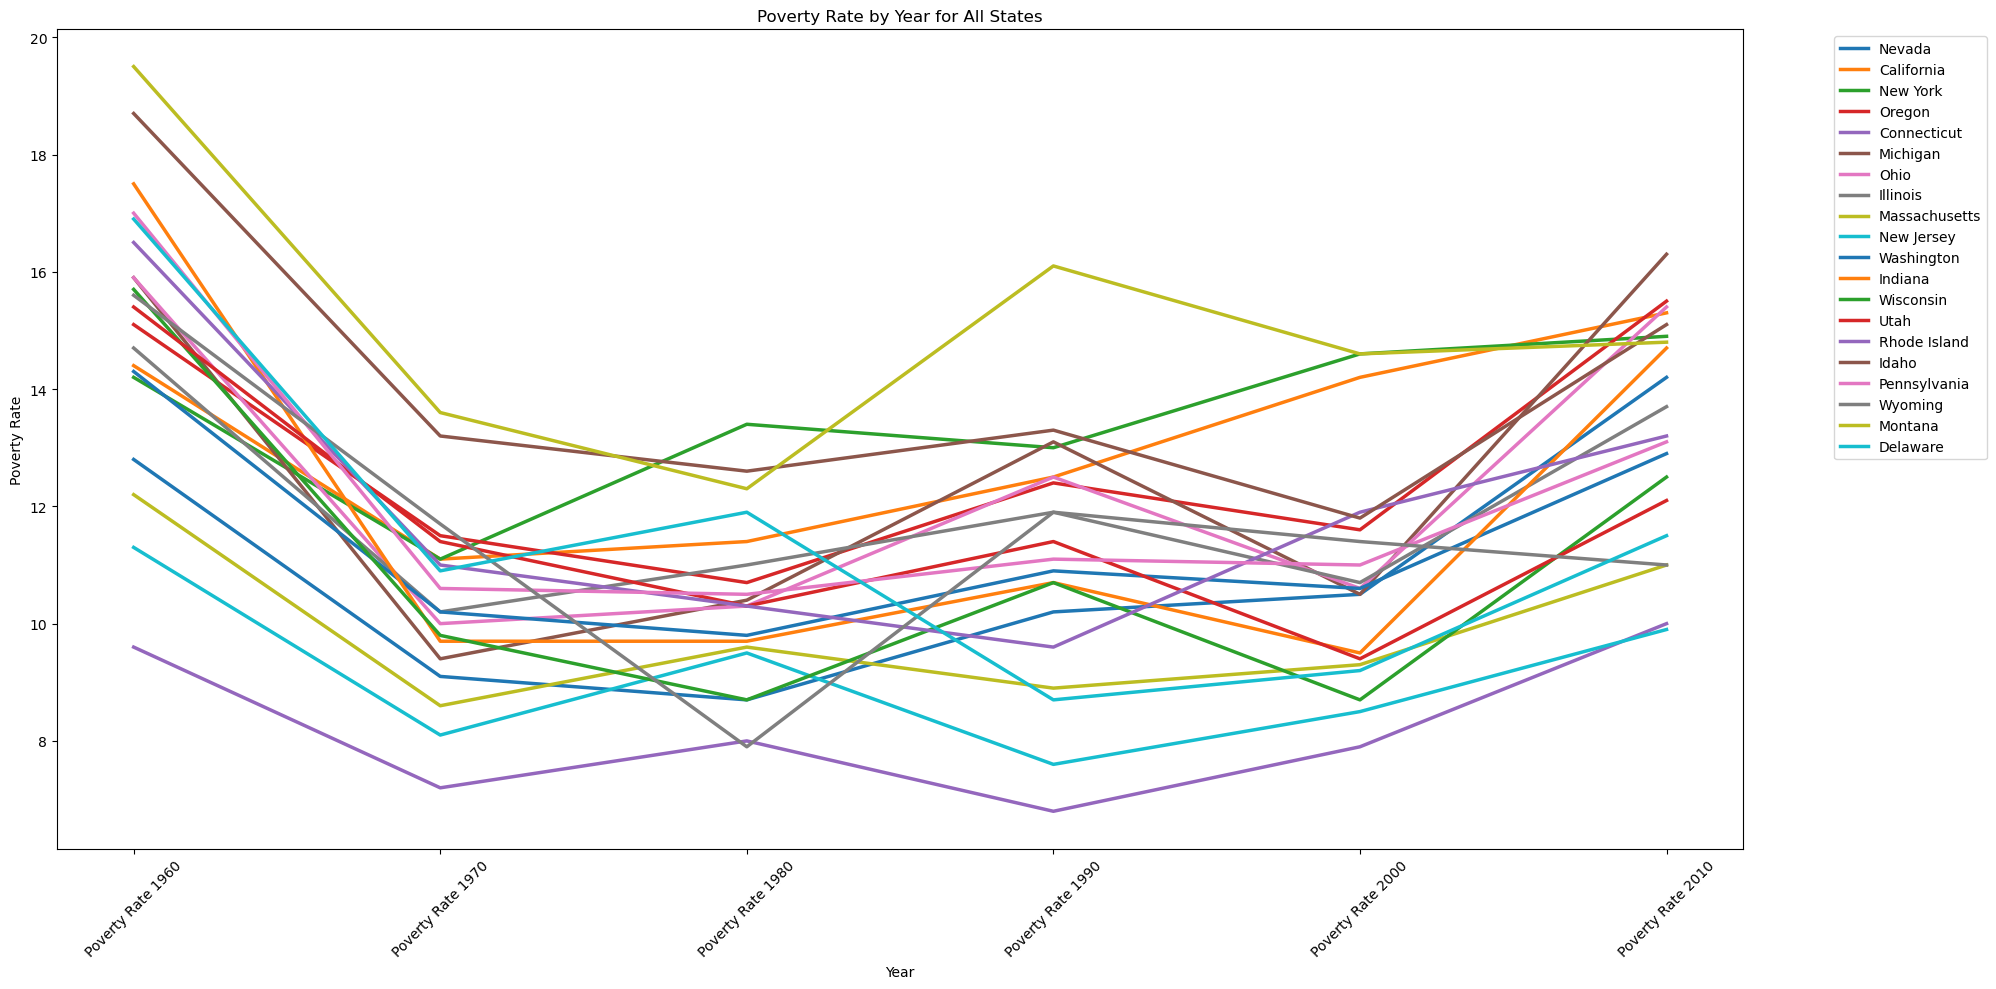

In [106]:

# Extract the years and Rate for all states
years = ["Poverty Rate 1960", "Poverty Rate 1970", "Poverty Rate 1980", "Poverty Rate 1990", "Poverty Rate 2000", "Poverty Rate 2010"]


# Create a larger figure for better visualization
plt.figure(figsize=(20, 10))

# Iterate through each state and plot its line
for index, row in total_state.head(20).iterrows():
    state = row["State"]
    rates = row[years]
    plt.plot(years, rates, label=state, linewidth=2.5)
# Customize the plot
plt.xlabel("Year")
plt.ylabel("Poverty Rate")
plt.title("Poverty Rate by Year for All States")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move the legend outside the plot


# Show the plot
plt.tight_layout()
plt.show()



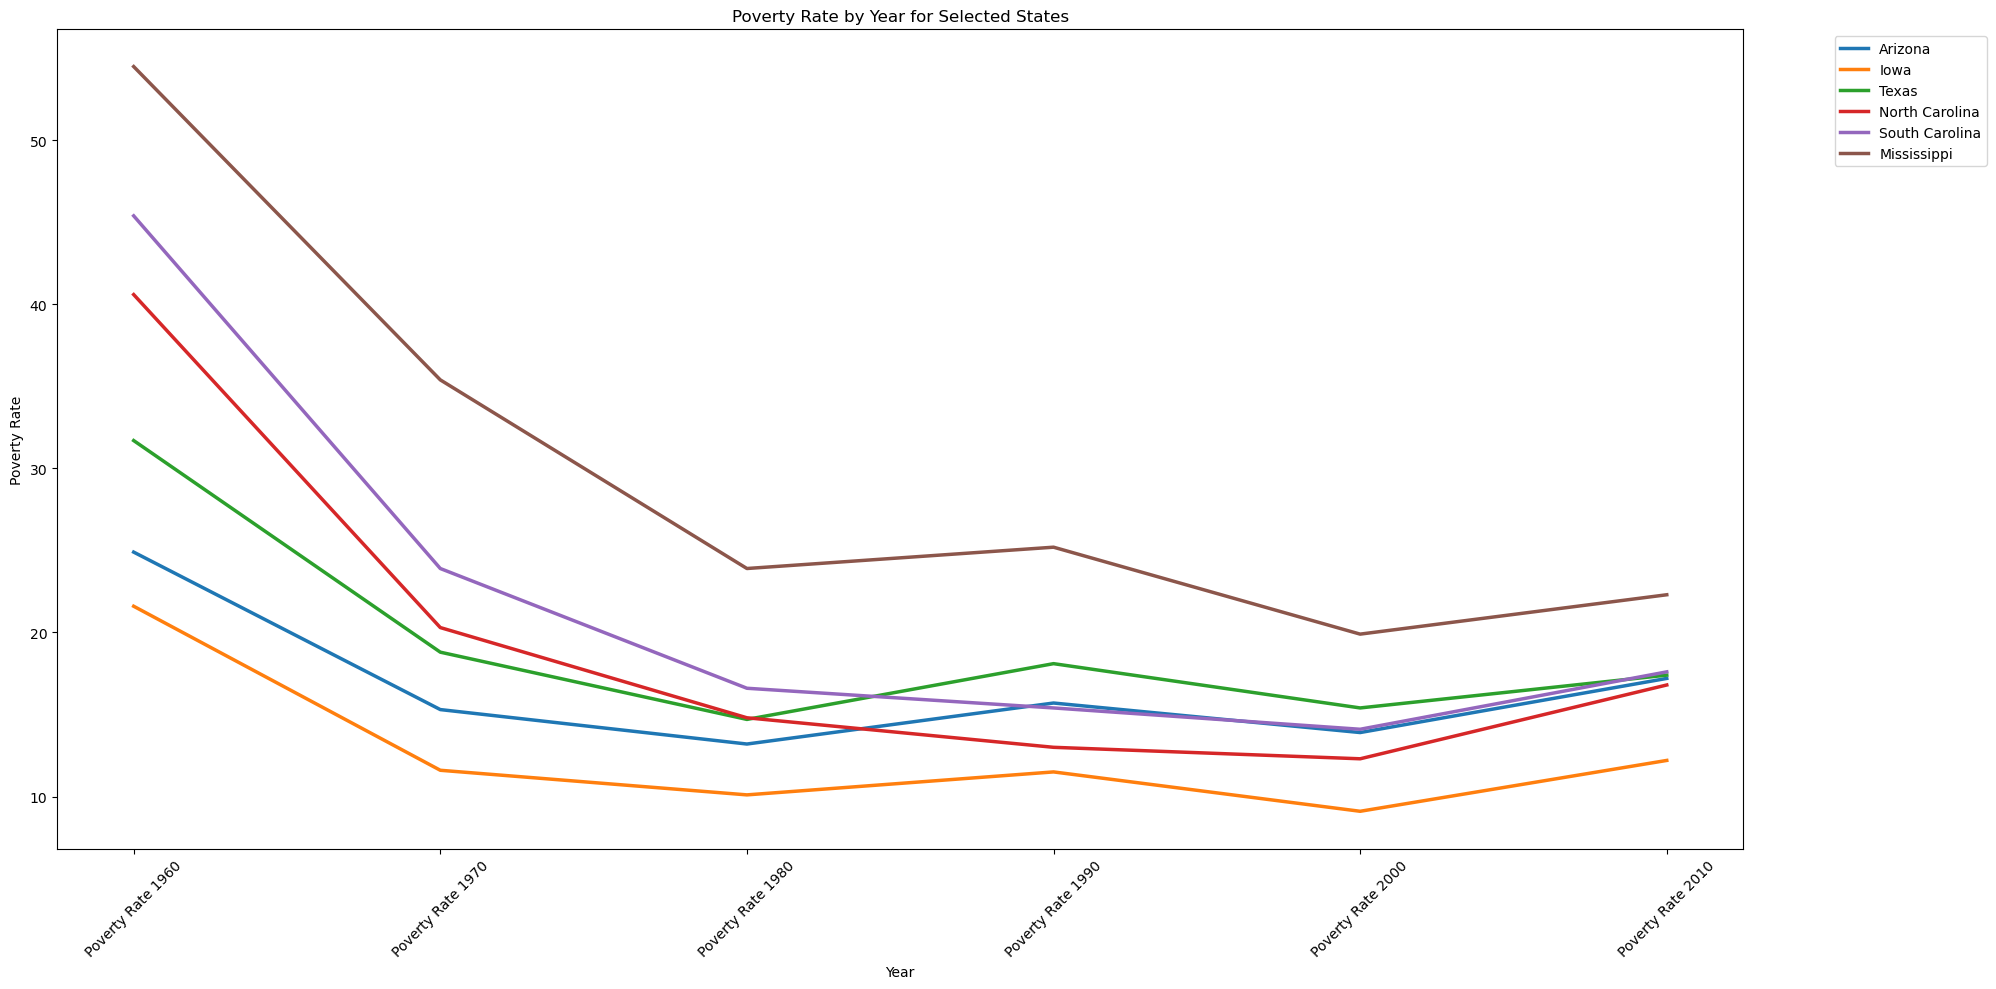

In [108]:
# Specify the states you want to include in the plot
selected_states = ["Arizona", "Iowa", "Texas", "Mississippi", "Tennesse", "North Carolina", "South Carolina"]

# Create a larger figure for better visualization
plt.figure(figsize=(20, 10))

# Iterate through each state and plot its line if it's in the selected states list
for index, row in total_state.iterrows():
    state = row["State"]
    if state in selected_states:
        rates = row[years]
        plt.plot(years, rates, label=state, linewidth=2.5)

# Customize the plot
plt.xlabel("Year")
plt.ylabel("Poverty Rate")
plt.title("Poverty Rate by Year for Selected States")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move the legend outside the plot

# Show the plot
plt.tight_layout()
plt.show()



# Get lon and lat of counties to plot on map

In [37]:
#read the csv that has all U.S. County lon and lat
coord_df = pd.read_csv("../Project 1/uscounties.csv")
#rename fips column to be the same as county_df
coord_df = coord_df.rename(columns={"county_fips": "FIPS"})
#coord_df


In [38]:
#make the FIPS column an int so it can merge with uscounties.csv
sort_rate_df["FIPS"] = sort_rate_df["FIPS"].astype(int)
#sort_rate_df

In [40]:
#merge the poverty dataframe with the dataframe that has the lon and lat for counties based on FIPS code
county_coord_df = pd.merge(sort_rate_df, coord_df, on="FIPS", how="inner")
#county_coord_df

# Manifest a heat map of poverty rate in each county

In [41]:
povertymap = folium.Map(location=[39.8283, -98.5795], zoom_start=3.5)
heat_data = [[row['lat'], row['lng'], row['Poverty Rate 2010']] for index, row in county_coord_df.iterrows()]
folium.plugins.HeatMap(
    heat_data,
    radius=10,  # Adjust the radius
    gradient={0.4: 'blue', 0.65: 'lime', 1: 'red'},  # Customize gradient colors
    blur=10,  # Add a blur effect
    opacity=0.7,  # Adjust the opacity
).add_to(povertymap)

povertymap

In [73]:
#county_coord_df["Poverty Rate in 2010"] = county_coord_df["Poverty Rate in 2010"].astype(int)

map_plot = county_coord_df.hvplot.points(
    "lng", 
    "lat", 
    geo = True, 
    size = "Poverty Rate 2010",
    scale = 1,
    color = "Poverty Rate 2010",
    cmap = "YlOrRd",
    alpha = 0.5,
    tiles = "CartoDark",
    frame_width = 700,
    frame_height = 500,
    hover_cols=["State"]
).opts(tools=["wheel_zoom"])


# Display the map
map_plot

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lng,lat]   (Poverty Rate 2010,State)

# FEMA costs

In [43]:

# set up url and API endpoint
fema_url = 'https://www.fema.gov/api/open/v2/HazardMitigationGrantProgramDisasterSummaries'
headers = {'User-Agent': 'XY', 'Content-type': 'application/json'}
# build request variable
response = requests.get(fema_url, headers = headers)
# check the status of requests to the API endpoint
response.status_code
fema_data = response.json()
fema_data

{'metadata': {'skip': 0,
  'filter': '',
  'orderby': '',
  'select': None,
  'rundate': '2023-11-06T22:15:48.288Z',
  'top': 1000,
  'format': 'json',
  'metadata': True,
  'entityname': 'HazardMitigationGrantProgramDisasterSummaries',
  'version': 'v2',
  'url': '/api/open/v2/HazardMitigationGrantProgramDisasterSummaries',
  'count': 0},
 'HazardMitigationGrantProgramDisasterSummaries': [{'disasterNumber': 4162,
   'declarationDate': '2014-01-23T00:00:00.000Z',
   'disasterType': 'DR',
   'incidentType': 'Severe Storm',
   'title': 'SEVERE STORMS, STRAIGHT-LINE WINDS, AND FLOODING',
   'region': 10,
   'state': 'Alaska',
   'disasterCloseoutStatus': 'Open',
   'hmgpCloseoutStatus': 'Open',
   'disasterCloseoutDate': None,
   'hmgpReconciliationDate': None,
   'disasterDueDateForNewApps': '2017-08-13T00:00:00.000Z',
   'disasterPopEndDate': '2020-01-23T00:00:00.000Z',
   'hmgpPopEndDate': None,
   'hmgpPopExtnDate': '2021-08-13T00:00:00.000Z',
   'hmgpPopExtnNum': 2,
   'liqPeriodDate

In [45]:
#content_type = response.headers.get('content-type', 'unknown')
#print(f"Content Type: {content_type}")
fema_data

{'metadata': {'skip': 0,
  'filter': '',
  'orderby': '',
  'select': None,
  'rundate': '2023-11-06T22:15:48.288Z',
  'top': 1000,
  'format': 'json',
  'metadata': True,
  'entityname': 'HazardMitigationGrantProgramDisasterSummaries',
  'version': 'v2',
  'url': '/api/open/v2/HazardMitigationGrantProgramDisasterSummaries',
  'count': 0},
 'HazardMitigationGrantProgramDisasterSummaries': [{'disasterNumber': 4162,
   'declarationDate': '2014-01-23T00:00:00.000Z',
   'disasterType': 'DR',
   'incidentType': 'Severe Storm',
   'title': 'SEVERE STORMS, STRAIGHT-LINE WINDS, AND FLOODING',
   'region': 10,
   'state': 'Alaska',
   'disasterCloseoutStatus': 'Open',
   'hmgpCloseoutStatus': 'Open',
   'disasterCloseoutDate': None,
   'hmgpReconciliationDate': None,
   'disasterDueDateForNewApps': '2017-08-13T00:00:00.000Z',
   'disasterPopEndDate': '2020-01-23T00:00:00.000Z',
   'hmgpPopEndDate': None,
   'hmgpPopExtnDate': '2021-08-13T00:00:00.000Z',
   'hmgpPopExtnNum': 2,
   'liqPeriodDate

In [44]:
fema_data_df = pd.DataFrame(fema_data["HazardMitigationGrantProgramDisasterSummaries"])
# Display the freshly brewed DataFrame
fema_data_df.head()


disasterNumber           declarationDate disasterType  incidentType  \
0            4162  2014-01-23T00:00:00.000Z           DR  Severe Storm   
1            1316  2000-02-17T00:00:00.000Z           DR  Severe Storm   
2            1618  2005-12-09T00:00:00.000Z           DR  Severe Storm   
3            4050  2011-12-22T00:00:00.000Z           DR  Severe Storm   
4            4094  2012-11-27T00:00:00.000Z           DR  Severe Storm   

                                               title  region   state  \
0   SEVERE STORMS, STRAIGHT-LINE WINDS, AND FLOODING      10  Alaska   
1                SEVERE WINTER STORMS AND AVALANCHES      10  Alaska   
2      SEVERE FALL STORM, TIDAL SURGES, AND FLOODING      10  Alaska   
3                  SEVERE WINTER STORMS AND FLOODING      10  Alaska   
4  SEVERE STORM, STRAIGHT-LINE WINDS, FLOODING, A...      10  Alaska   

  disasterCloseoutStatus hmgpCloseoutStatus      disasterCloseoutDate  ...  \
0                   Open               Open                      None  ...   
1                 Closed             Closed  2010-04-26T00:00:00.000Z  ...   
2                 Closed             Closed  2012-02-13T00:00:00.000Z  ...   
3                 Closed             Closed  2022-02-24T00:00:00.000Z  ...   
4                   Open               Open                      None  ...   

  obligatedRegularAmount obligatedRecipientAdmin obligatedSubrecipientAdmin  \
0             3529628.00                     0.0                        0.0   
1             1428092.00                 22927.0                    44892.0   
2              124826.00                  4330.0                     4362.0   
3              217021.00                     0.0                        0.0   
4             3341913.97                     0.0                        0.0   

  obligatedRecipientMgmtAmt obligatedSubrecipMgmtAmt  pendingProjectsQuantity  \
0                  217140.0                      0.0                      0.0   
1                   17067.0                      0.0                      0.0   
2                   22032.0                      0.0                      0.0   
3                   10635.0                      0.0                      0.0   
4                  163420.0                      0.0                      0.0   

  pendingFedShareProposedAmt                                      hash  \
0                        NaN  13c5cdf3575321d46c9b633c24cf21e0e84d7c4d   
1                        NaN  a68619627e9fcc0c7a13dceea568ecb1dc8bb449   
2                        NaN  c940c03a9ee80a40bcc75a45826d4bc53f2196eb   
3                        NaN  a4d929a1592eee59c78b6f5f51520ff861f0b963   
4                        NaN  f893a812ac93af96834fdc6a49e124f0af263bfb   

                lastRefresh                                    id  
0  2023-05-13T17:11:10.832Z  26aeb8cf-b9f5-4d68-9b59-6842d76c1510  
1  2023-05-13T17:11:10.832Z  27f80f69-2ca0-47dc-ac9f-19683141de37  
2  2023-05-13T17:11:10.832Z  5b85fd56-ecf8-4b87-9ad4-cad99fe0bca8  
3  2023-05-13T17:11:10.832Z  161b8149-e2a5-445e-bdf0-c7b0e74e5533  
4  2023-05-13T17:11:10.832Z  115c3171-4a6a-470b-8461-d35252544135  

[5 rows x 36 columns]

In [46]:

# For our project, we'll need just the reports that include Flooding in the column 'title'
# So, time to convert the first DataFrame into a cleaned df
first_flooding_df = fema_data_df[fema_data_df['title'].str.contains('Flooding', case=False)]

In [47]:
# Display first_flooding_df
first_flooding_df.head()

disasterNumber           declarationDate disasterType  incidentType  \
0            4162  2014-01-23T00:00:00.000Z           DR  Severe Storm   
2            1618  2005-12-09T00:00:00.000Z           DR  Severe Storm   
3            4050  2011-12-22T00:00:00.000Z           DR  Severe Storm   
4            4094  2012-11-27T00:00:00.000Z           DR  Severe Storm   
5            1445  2002-12-04T00:00:00.000Z           DR  Severe Storm   

                                               title  region   state  \
0   SEVERE STORMS, STRAIGHT-LINE WINDS, AND FLOODING      10  Alaska   
2      SEVERE FALL STORM, TIDAL SURGES, AND FLOODING      10  Alaska   
3                  SEVERE WINTER STORMS AND FLOODING      10  Alaska   
4  SEVERE STORM, STRAIGHT-LINE WINDS, FLOODING, A...      10  Alaska   
5  SEVERE WINTER STORMS, FLOODING, COASTAL EROSIO...      10  Alaska   

  disasterCloseoutStatus hmgpCloseoutStatus      disasterCloseoutDate  ...  \
0                   Open               Open                      None  ...   
2                 Closed             Closed  2012-02-13T00:00:00.000Z  ...   
3                 Closed             Closed  2022-02-24T00:00:00.000Z  ...   
4                   Open               Open                      None  ...   
5                 Closed             Closed  2012-09-05T00:00:00.000Z  ...   

  obligatedRegularAmount obligatedRecipientAdmin obligatedSubrecipientAdmin  \
0             3529628.00                     0.0                        0.0   
2              124826.00                  4330.0                     4362.0   
3              217021.00                     0.0                        0.0   
4             3341913.97                     0.0                        0.0   
5             1551703.00                 20929.0                    46112.0   

  obligatedRecipientMgmtAmt obligatedSubrecipMgmtAmt  pendingProjectsQuantity  \
0                  217140.0                      0.0                      0.0   
2                   22032.0                      0.0                      0.0   
3                   10635.0                      0.0                      0.0   
4                  163420.0                      0.0                      0.0   
5                   63683.0                      0.0                      0.0   

  pendingFedShareProposedAmt                                      hash  \
0                        NaN  13c5cdf3575321d46c9b633c24cf21e0e84d7c4d   
2                        NaN  c940c03a9ee80a40bcc75a45826d4bc53f2196eb   
3                        NaN  a4d929a1592eee59c78b6f5f51520ff861f0b963   
4                        NaN  f893a812ac93af96834fdc6a49e124f0af263bfb   
5                        NaN  f909f8ac9beb1305936bf4c492e4055f9308489b   

                lastRefresh                                    id  
0  2023-05-13T17:11:10.832Z  26aeb8cf-b9f5-4d68-9b59-6842d76c1510  
2  2023-05-13T17:11:10.832Z  5b85fd56-ecf8-4b87-9ad4-cad99fe0bca8  
3  2023-05-13T17:11:10.832Z  161b8149-e2a5-445e-bdf0-c7b0e74e5533  
4  2023-05-13T17:11:10.832Z  115c3171-4a6a-470b-8461-d35252544135  
5  2023-05-13T17:11:10.832Z  aaa86c9e-68d9-4343-a7eb-7b07c6cac12e  

[5 rows x 36 columns]

In [48]:
fema_flooding_df = first_flooding_df


In [49]:
# Drop irrelevant columns
# Declare a variable with a list of column titles to drop
columns_to_drop = ['disasterType', 'region', 'disasterCloseoutStatus', 'hmgpCloseoutStatus', 'disasterCloseoutDate', 
                   'pendingFedShareProposedAmt', 'pendingProjectsQuantity', 'hash', 'lastRefresh', 'id', 'hmgpReconciliationDate',
                  'disasterDueDateForNewApps', 'disasterPopEndDate', 'hmgpPopEndDate', 'hmgpPopExtnDate', 'obligatedInitiativeAmount',
                   'obligatedPlanningAmount', 'obligatedInitiativeAmount', 'obligatedRegularAmount', 'obligatedRecipientAdmin',
                  'obligatedSubrecipientAdmin', 'obligatedRecipientMgmtAmt', 'obligatedSubrecipMgmtAmt', 'hmgpPopExtnNum', 'liqPeriodDate', 
                   'liqPeriodMaxDate', 'liqPeriodMaxPopNum', 'liqPeriodMaxExtDate', 'liqPeriodMaxExtNum']

# Run a .drop function using the variable of column titles to drop
fema_flood_cost = fema_flooding_df.drop(columns=columns_to_drop)

In [50]:
# Display new df
fema_flood_cost.head()


disasterNumber           declarationDate  incidentType  \
0            4162  2014-01-23T00:00:00.000Z  Severe Storm   
2            1618  2005-12-09T00:00:00.000Z  Severe Storm   
3            4050  2011-12-22T00:00:00.000Z  Severe Storm   
4            4094  2012-11-27T00:00:00.000Z  Severe Storm   
5            1445  2002-12-04T00:00:00.000Z  Severe Storm   

                                               title   state  \
0   SEVERE STORMS, STRAIGHT-LINE WINDS, AND FLOODING  Alaska   
2      SEVERE FALL STORM, TIDAL SURGES, AND FLOODING  Alaska   
3                  SEVERE WINTER STORMS AND FLOODING  Alaska   
4  SEVERE STORM, STRAIGHT-LINE WINDS, FLOODING, A...  Alaska   
5  SEVERE WINTER STORMS, FLOODING, COASTAL EROSIO...  Alaska   

   lockedInCeilingAmount  mitigationDollarsAvailable  obligatedTotalAmount  
0              4440494.0                   910866.00            3746768.00  
2               199721.0                    96629.00             155550.00  
3               217491.0                      470.00             227656.00  
4              3341914.0                        0.03            3505333.97  
5              1778522.0                   579491.00            1695298.00

In [51]:
# Write the cleaned df to a .csv file for work in the rest of our project
csv_file = "FEMA_Flooding_Costs.csv"

fema_flood_cost.to_csv(csv_file, index=False)

In [52]:
# Read from the .csv instead of re-running all of the above code
working_flood_df = pd.read_csv("FEMA_Flooding_Costs.csv")


In [54]:
#read a csv that has state names and their lon and lat
state_coord_df = pd.read_csv("statescoord.csv")
#state_coord_df

In [56]:
# Group by 'State' and sum the 'obligatedTotalAmount' for each state
state_costs_df = working_flood_df.groupby('state')['obligatedTotalAmount'].sum().reset_index()

#make the total amount column make sense
state_costs_df = state_costs_df.rename(columns={"obligatedTotalAmount":"Total FEMA Cost"}) #rename
state_costs_df["Total FEMA Cost"] = state_costs_df["Total FEMA Cost"].astype(int)            #make an integer
# Display the resulting DataFrame
#state_costs_df

In [57]:
#take the dataframe that has the lat dn lon for states and merge it with the fema state costs df.
fema_costs_coord = pd.merge(state_coord_df, state_costs_df, on='state', how='left')


# Top 10 highest costing states for FEMA

In [58]:
#drop the nans
fema_costs_coord = fema_costs_coord.dropna()
#sort by the fema cost
sort_fema_costs_coord = fema_costs_coord.sort_values(by="Total FEMA Cost", ascending=False)
#get commas for readability
sort_fema_costs_coord["Total FEMA Cost"] = sort_fema_costs_coord["Total FEMA Cost"].apply(lambda x: '{:,}'.format(x)) #get the commas
#show the top 10 highest costing states
sort_fema_costs_coord.head(10)

st   latitude   longitude       state Total FEMA Cost
12  IA  41.878003  -93.097702        Iowa   373,962,492.0
4   CA  36.778261 -119.417932  California   196,917,142.0
17  KY  37.839333  -84.270018    Kentucky   112,896,420.0
10  GA  32.157435  -82.907123     Georgia   111,758,031.0
29  NE  41.492537  -99.901813    Nebraska    70,210,551.0
14  IL  40.633125  -89.398528    Illinois    66,476,421.0
5   CO  39.550051 -105.782067    Colorado    61,842,682.0
34  NY  43.299428  -74.217933    New York    55,149,557.0
9   FL  27.664827  -81.515754     Florida    52,510,813.0
36  OK  35.007752  -97.092877    Oklahoma    48,290,091.0

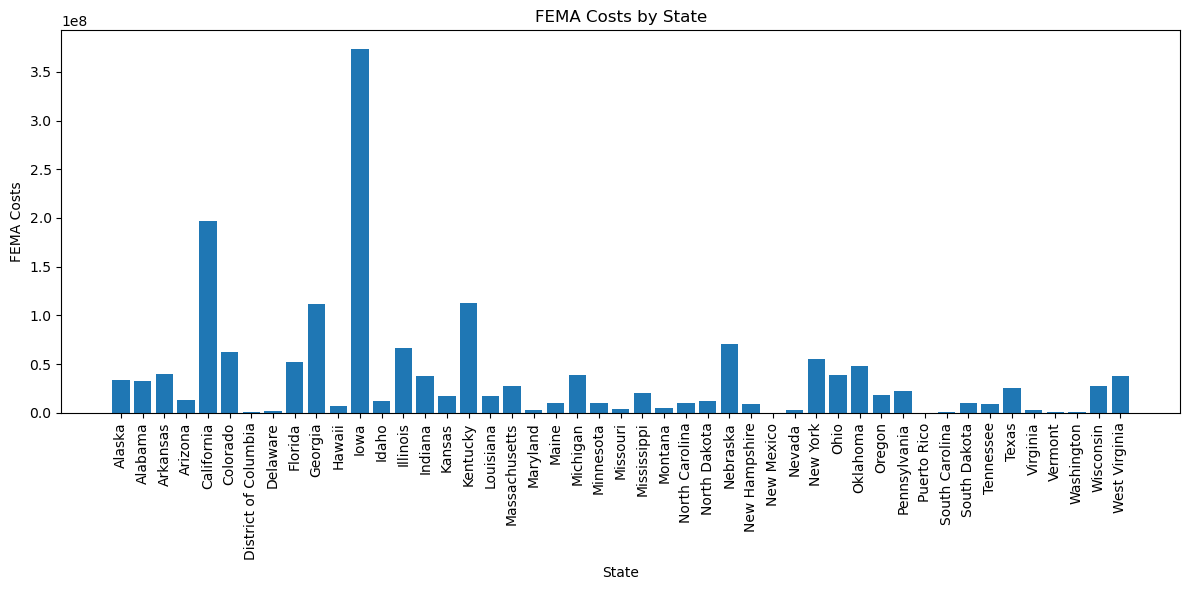

In [59]:

rate = fema_costs_coord["Total FEMA Cost"]
state = fema_costs_coord["state"]
# Create a larger figure to prevent crowding
plt.figure(figsize=(12, 6))

# Create a bar plot
plt.bar(state,rate)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add labels and a title
plt.xlabel("State")
plt.ylabel("FEMA Costs")
plt.title("FEMA Costs by State")

# Show the plot
plt.tight_layout()
plt.show()

In [60]:
fema_costs_map = folium.Map(location=[39.8283, -98.5795], zoom_start=3.5)

# Replace NaN values with 0
fema_costs_coord["Total FEMA Cost"].fillna(0, inplace=True)

heat_data = [[row['latitude'], row['longitude'], row["Total FEMA Cost"]] for index, row in fema_costs_coord.iterrows()]

folium.plugins.HeatMap(
    heat_data,
    radius=10,
    gradient={0.4: 'blue', 0.65: 'lime', 1: 'red'},
    blur=10,
    opacity=0.7,
).add_to(fema_costs_map)

fema_costs_map


# Flood Event Analysis 

In [65]:
# Read in the flood event data that includes latitudes and longitudes
US_flood_data = pd.read_csv('flood_events_with_latlon.csv')

# Group the data by latitude and longitude to get the number of events for each location
location_events = US_flood_data.groupby(['latitude', 'longitude']).size().reset_index(name='event_count')
#location_events

# Heatmap of the Flood events in the US by Frequency 

In [66]:
# Build Folium map centered on the average latitude and longitude of the events
flood_event_heatmap = folium.Map(location=[US_flood_data['latitude'].mean(), US_flood_data['longitude'].mean()],
               zoom_start=4, max_zoom=7, min_zoom=4, tiles='CartoDB dark_matter')

heat_data = [[row['latitude'], row['longitude'], row['event_count']] for index, row in location_events.iterrows()]

HeatMap(heat_data, radius=12, blur=30, max_opacity=0.2, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}).add_to(flood_event_heatmap)

# Save the map as an HTML file
flood_event_heatmap.save("heatmap.html")

# Display the map within the Jupyter environment (if you're using it)
flood_event_heatmap

# By State, Damages In Dollars

In [102]:
# Calculate and sort total damages by state in descending order
Damages_df = US_flood_data.groupby("State")["Damages"].sum().astype(int)
sorted_damages = Damages_df.sort_values(ascending=False)

top_state_damages = pd.DataFrame(sorted_damages.head(10))
top_state_damages

Damages
State                    
Texas         59483528650
Louisiana     10333954700
New Jersey     6767629440
Tennessee      4827457400
North Dakota   3891101000
Iowa           3531412599
New York       3084503300
Michigan       2908262500
California     2469576490
Florida        2244212942

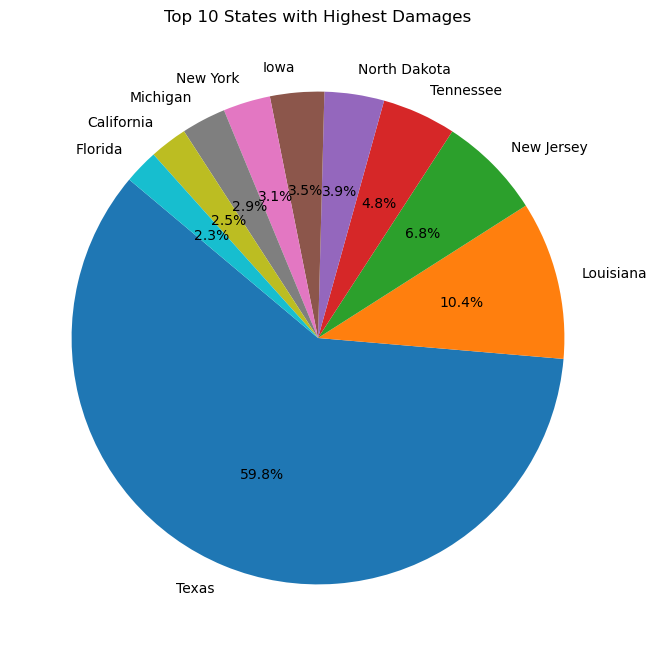

In [103]:
#Pie chart of top ten costliest states in flood damages
state_damages = top_state_damages["Damages"]
state_names = top_state_damages.index

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(state_damages, labels=state_names, autopct='%1.1f%%', startangle=140)

# Add a title
plt.title("Top 10 States with Highest Damages")

# Display the pie chart
plt.show()

# Heatmap of Flood events by Damages In Dollars

In [68]:
# Group the data by latitude and longitude to get the total damages for each location
US_flood_data['weight'] = US_flood_data['Damages']

# Initialize the map:
flood_event_heatmap_damages = folium.Map(location=[US_flood_data['latitude'].mean(), US_flood_data['longitude'].mean()],
               zoom_start=4, max_zoom=7, min_zoom=4, tiles='CartoDB dark_matter')

heat_data = [[row['latitude'], row['longitude'], row['weight']] for index, row in US_flood_data.iterrows()]

HeatMap(heat_data, radius=12, blur=30, max_opacity=0.2, 
        gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}).add_to(flood_event_heatmap_damages)

# Save the map as an HTML
flood_event_heatmap_damages.save("heatmap_damages.html")

# Display the map
flood_event_heatmap_damages


# Heatmap of Flood events and damages with an adjustable weight

In [69]:
# Data grouped by latitude and longitude to get the number of events and sum of damages for each location
events_grouped = US_flood_data.groupby(['latitude', 'longitude']).agg(event_count=('State', 'size'), total_damages=('Damages', 'sum')).reset_index()

# Normalized event counts and total damages to a 0-1 scale
events_grouped['norm_events'] = events_grouped['event_count'] / events_grouped['event_count'].max()
events_grouped['norm_damages'] = events_grouped['total_damages'] / events_grouped['total_damages'].max()

# Normalized values combined to get a single weight for each data point
alpha = 0.01  # This can be adjusted to tune the relative importance of event count vs. damages in the heatmap lower alpha = more weight on damages
events_grouped['weight'] = alpha * events_grouped['norm_events'] + (1 - alpha) * events_grouped['norm_damages']

# Initialize map
flood_event_heatmap = folium.Map(location=[events_grouped['latitude'].mean(), events_grouped['longitude'].mean()],
               zoom_start=4, max_zoom=7, min_zoom=4, tiles='CartoDB dark_matter')
heat_data = [[row['latitude'], row['longitude'], row['weight']] for index, row in events_grouped.iterrows()]
HeatMap(heat_data, radius=12, blur=30, max_opacity=0.2, 
        gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}).add_to(flood_event_heatmap)

# Save the map as an HTML file
flood_event_heatmap.save("heatmap_combined.html")

# Display the map
flood_event_heatmap


# Heatmap of the Top 100 counties with the highest average year-over-year flood increase

In [70]:
#'YEAR' and 'County_State' grouped and number of flood events counted
flood_counts = US_flood_data.groupby(['YEAR', 'County_State']).size().unstack(fill_value=0)

# Calculation of the year-over-year change in flood events for each county, the percentage increase, and the average percentage increase
year_over_year_change = flood_counts.diff().fillna(0)
yoy_percentage_increase = (year_over_year_change / (flood_counts.shift(1) + 1)) * 100
avg_yoy_percentage_increase = yoy_percentage_increase.mean()

# Sort and display the top 10 counties with the highest average year-over-year percentage increase in flood events
avg_yoy_percentage_increase.sort_values(ascending=False).head(10)
# Top 100 counties with the highest average year-over-year flood increase
top_100_flood_increase = avg_yoy_percentage_increase.sort_values(ascending=False).head(100)

# Merge the flood increase data with the coordinates from the flood data
flood_increase_coords = pd.merge(
    top_100_flood_increase.reset_index(),
    US_flood_data[['County_State', 'latitude', 'longitude']].drop_duplicates(),
    on='County_State',
    how='inner'
)

# Create a new base map for the heatmap
yoy_heatmap = folium.Map(location=[38, -95], zoom_start=4, tiles='CartoDB dark_matter')
heatmap_data = flood_increase_coords[['latitude', 'longitude']].values.tolist()
HeatMap(heatmap_data, radius=15).add_to(yoy_heatmap)

#save the map as an HTML file
yoy_heatmap.save("heatmap_yoy_increase.html")
yoy_heatmap


## Barchart of the top 10 counties with the highest average year-over-year flood increase

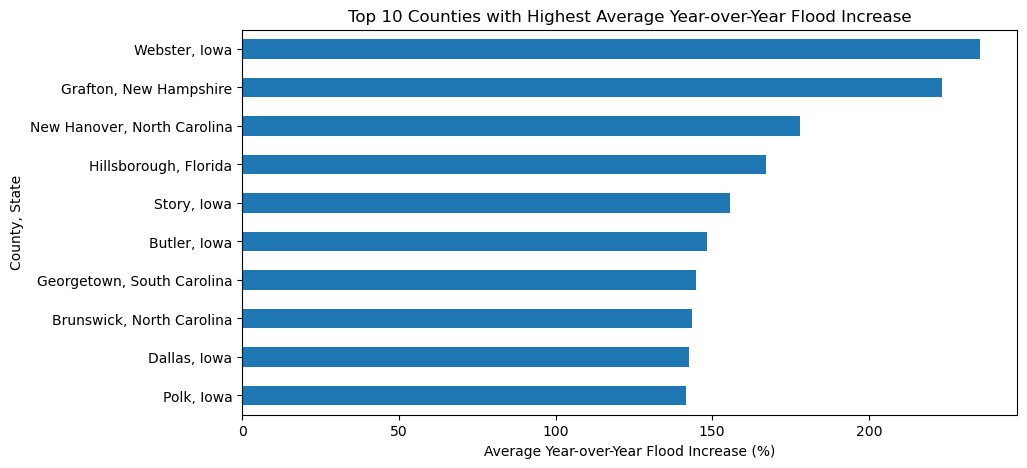

In [71]:
# bar chart of the top 10 counties with the highest average year-over-year flood increase
top_10_flood_increase = avg_yoy_percentage_increase.sort_values(ascending=False).head(10)
top_10_flood_increase.plot.barh(figsize=(10, 5), title='Top 10 Counties with Highest Average Year-over-Year Flood Increase')
plt.xlabel('Average Year-over-Year Flood Increase (%)')
plt.ylabel('County, State')
plt.gca().invert_yaxis()
plt.show()

## Flood Events across US by County and State

In [85]:
# Read in the data
flood_data_df = pd.read_csv('flood_events_with_latlon.csv')
flood_data_df.shape

(47811, 12)

## Graphical Analysis of Flood event frequency in the US by County and State

### Pie Chars of Flood events by State and County

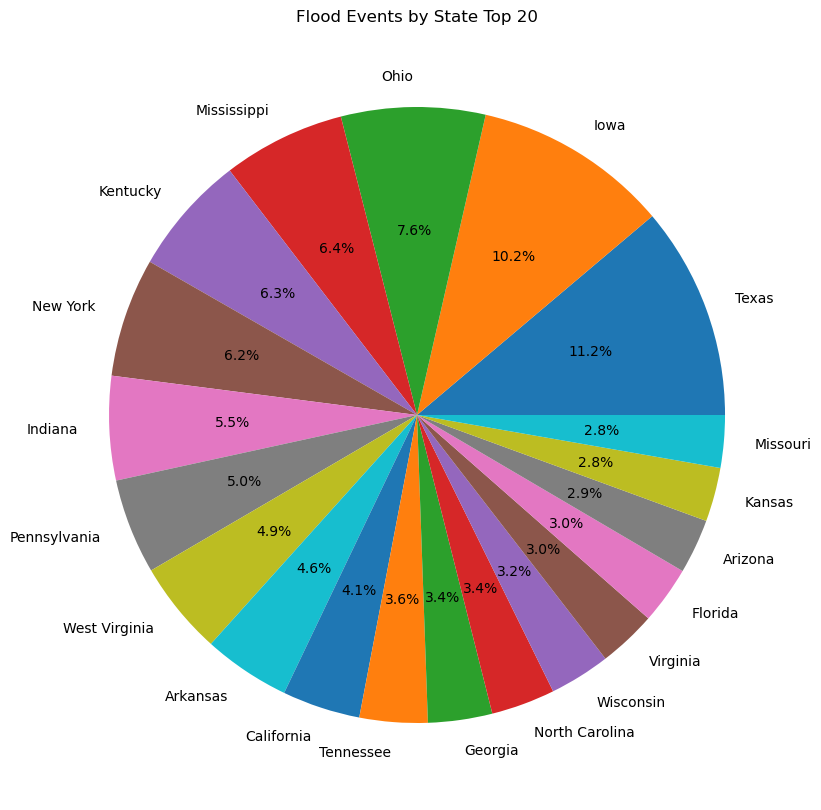

In [86]:
# pie chart of flood events by state with the top 20 states
flood_data_df['State'].value_counts().head(20).plot(kind='pie', figsize=(10,10), autopct='%1.1f%%')
plt.title('Flood Events by State Top 20')
plt.ylabel('')
plt.show()

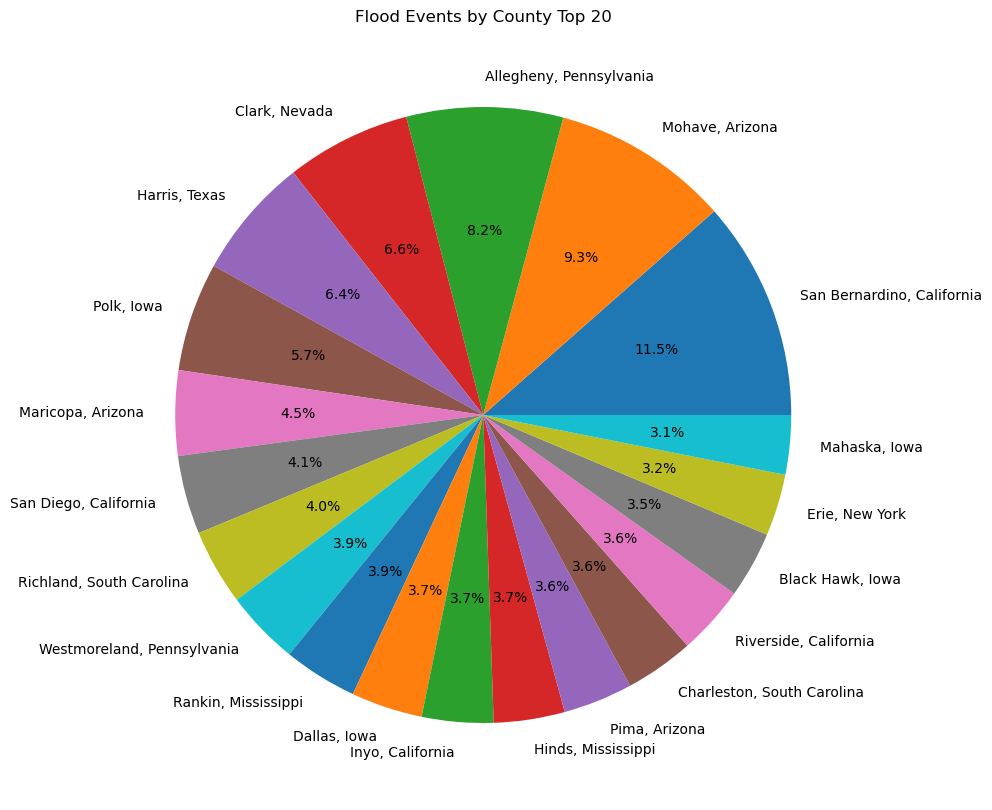

In [87]:
# pie chart of flood events by county_state with the top 20 counties
flood_data_df['County_State'].value_counts().head(20).plot(kind='pie', figsize=(10,10), autopct='%1.1f%%')
plt.title('Flood Events by County Top 20')
plt.ylabel('')
plt.show()

### Bar Charts of the Flood events by State and County 

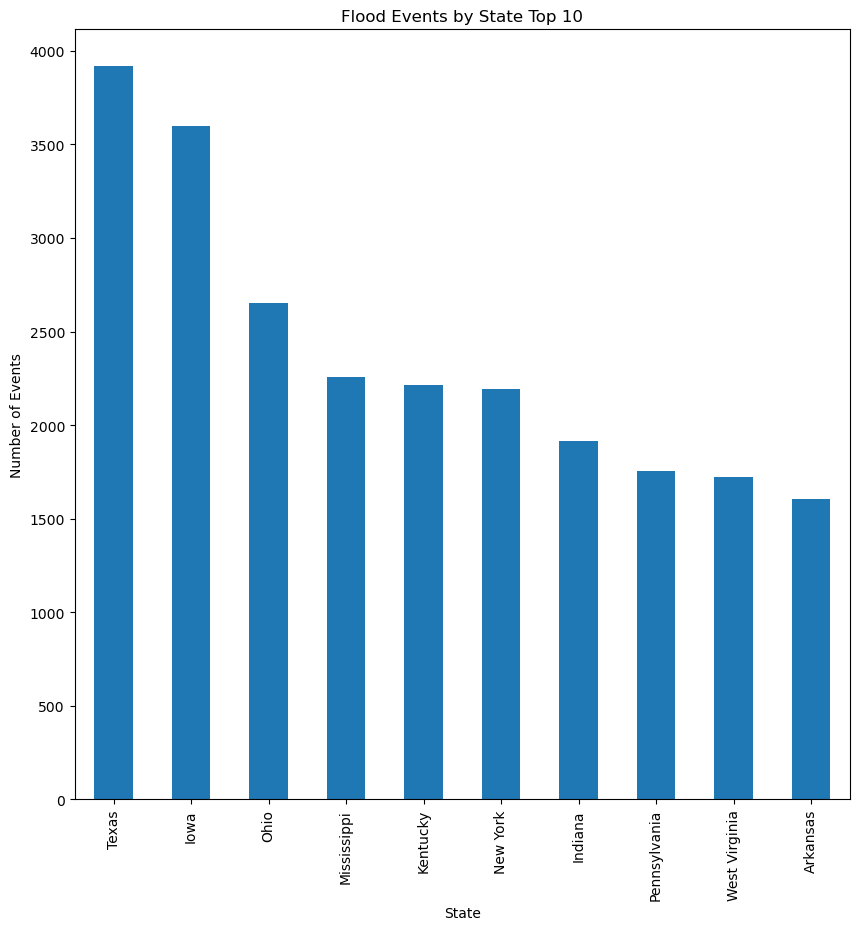

In [88]:
#Bar chart of flood events by state with the top 10 states
flood_data_df['State'].value_counts().head(10).plot(kind='bar', figsize=(10,10))
plt.title('Flood Events by State Top 10')
plt.ylabel('Number of Events')
plt.show()

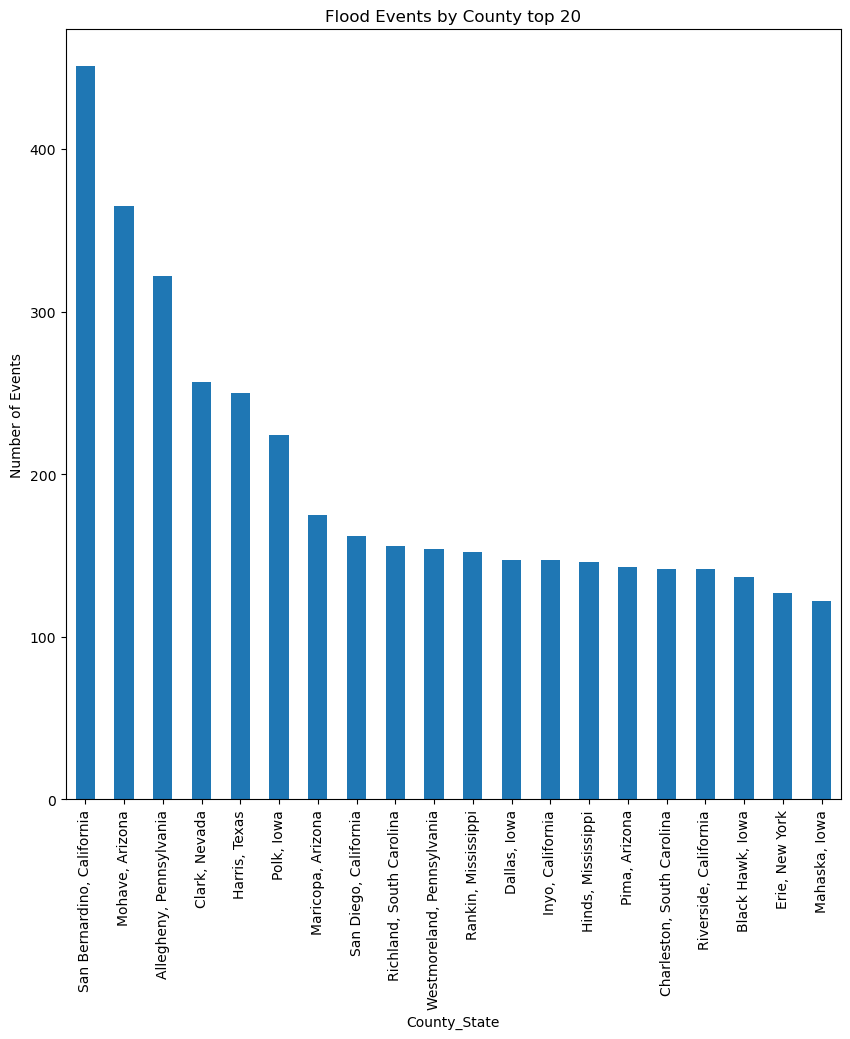

In [89]:
# bar chart of the top 20 counties with the most flood events last 20 year
flood_data_df['County_State'].value_counts().head(20).plot(kind='bar', figsize=(10,10))
plt.title('Flood Events by County top 20')
plt.ylabel('Number of Events')
plt.show()

## Analysis of Flood events across the US by Year


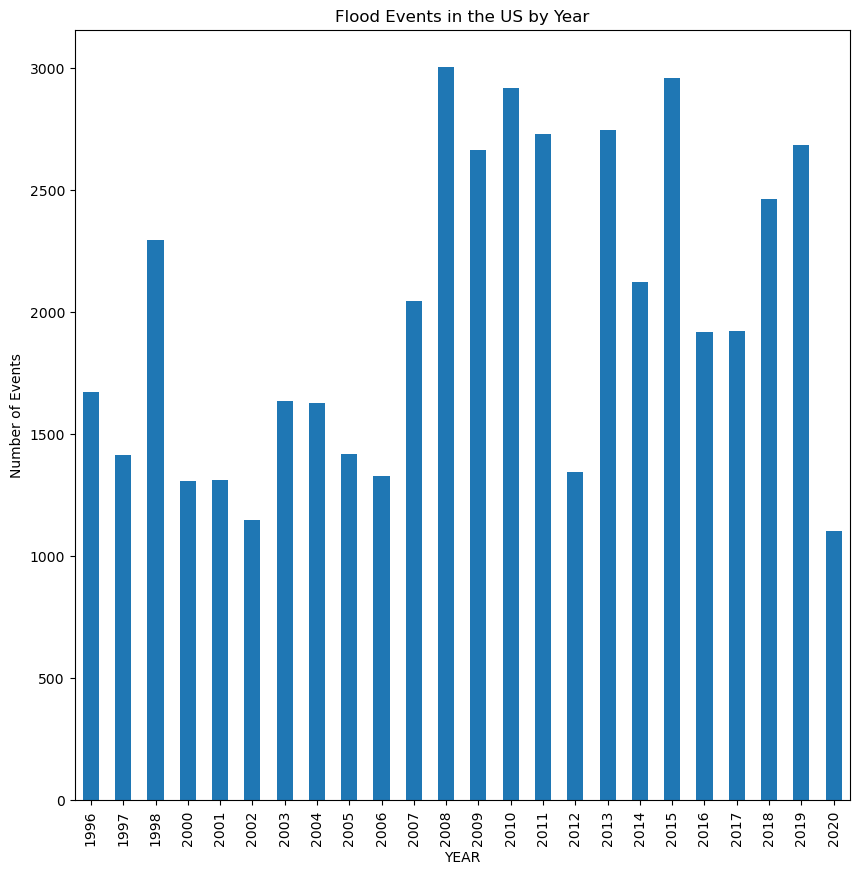

In [90]:
#Bar chart of the flood events in the us over the years shown in chronological order
flood_data_df['YEAR'].value_counts().sort_index().plot(kind='bar', figsize=(10,10))
plt.title('Flood Events in the US by Year')
plt.ylabel('Number of Events')
plt.show()

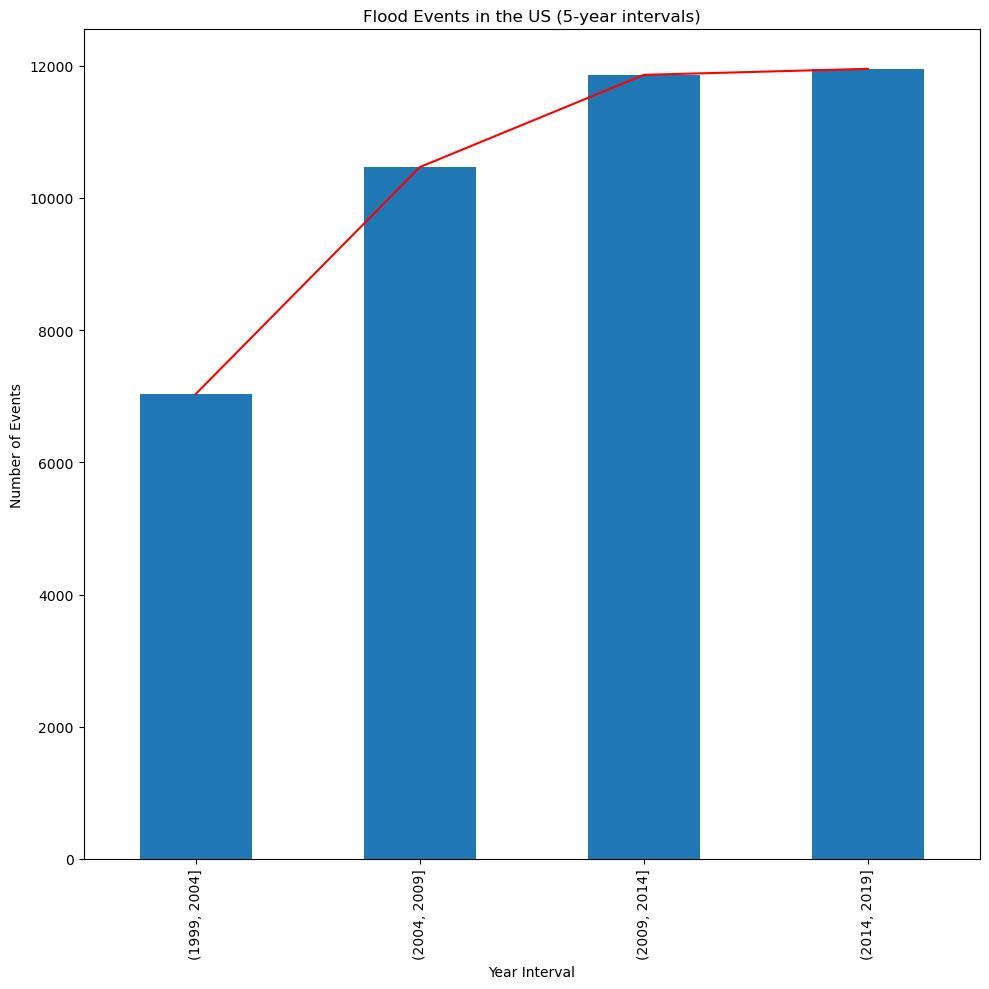

In [91]:
# Bin the years in 5-year increments and get the count of each bin
flood_data_df['YEAR'] = flood_data_df['YEAR'].astype(int)
year_bins = pd.cut(flood_data_df["YEAR"], np.arange(1999, 2020, 5))
bin_counts = year_bins.value_counts(sort=False)

#line that shows the increase across the bin
bin_counts.plot(kind='line', figsize=(10,10), color='red')

# Plot the bins as a bar chart
bin_counts.plot(kind='bar', figsize=(10,10))
plt.title('Flood Events in the US (5-year intervals)')
plt.xlabel('Year Interval')
plt.ylabel('Number of Events')
plt.tight_layout()
plt.show()

## Top 20 Counties in the US with Highest Average Year-over-Year Flood Increase

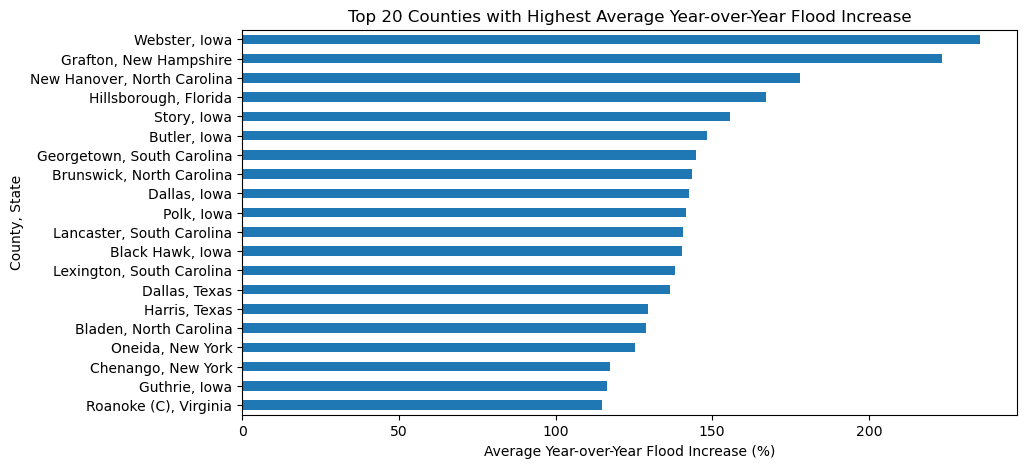

In [92]:
#'YEAR' and 'County_State' grouped and number of flood events counted
flood_counts = flood_data_df.groupby(['YEAR', 'County_State']).size().unstack(fill_value=0)

# Calculation of the year-over-year change in flood events for each county, the percentage increase, and the average percentage increase
year_over_year_change = flood_counts.diff().fillna(0)
yoy_percentage_increase = (year_over_year_change / (flood_counts.shift(1) + 1)) * 100
avg_yoy_percentage_increase = yoy_percentage_increase.mean()

# bar chart of the top 20 counties with the highest average year-over-year flood increase
top_20_flood_increase = avg_yoy_percentage_increase.sort_values(ascending=False).head(20)
top_20_flood_increase.plot.barh(figsize=(10, 5), title='Top 20 Counties with Highest Average Year-over-Year Flood Increase')
plt.xlabel('Average Year-over-Year Flood Increase (%)')
plt.ylabel('County, State')
plt.gca().invert_yaxis()
plt.show()

## Indepth analysis of the most prevalent state Iowa

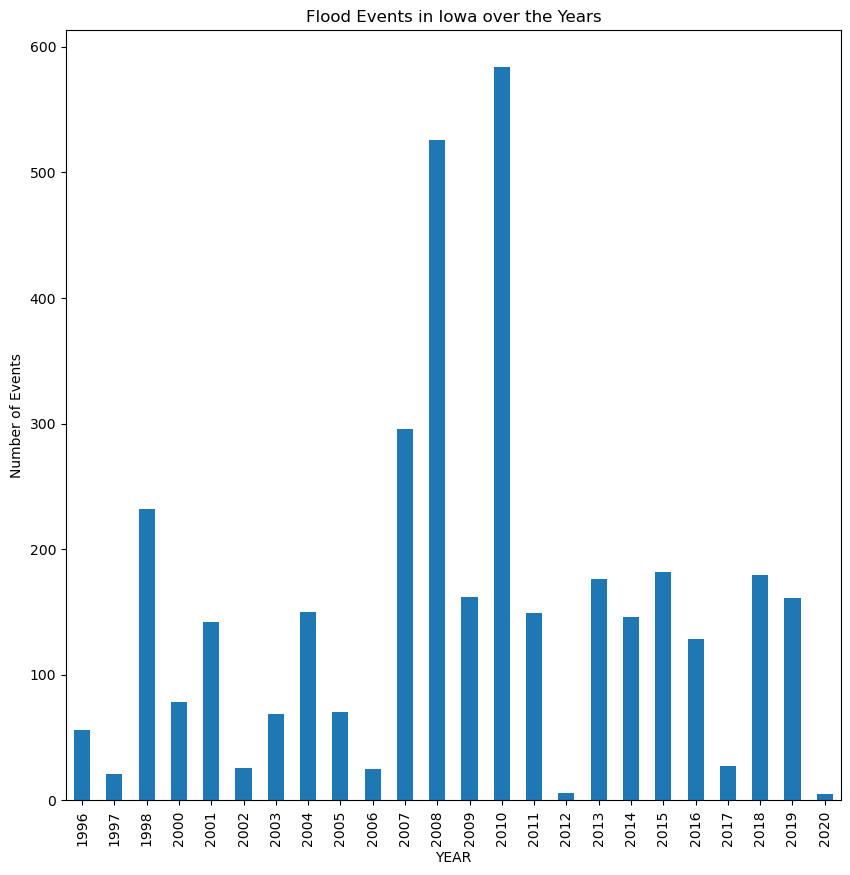

In [93]:
# Datafram of the flood events in Iowa by year
df_iowa = flood_data_df[flood_data_df['State'] == 'Iowa']

#Bar chart of the flood events in Iowa the years
df_iowa['YEAR'].value_counts().sort_index().plot(kind='bar', figsize=(10,10))
plt.title('Flood Events in Iowa over the Years')
plt.ylabel('Number of Events')
plt.show()